In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


In [2]:
train = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
test = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
y_train = train['label'].astype('float32')
X_train = train.drop(['label'], axis=1).astype('int32')
X_test = test.astype('float32')
X_train.shape, y_train.shape, X_test.shape

((42000, 784), (42000,), (28000, 784))

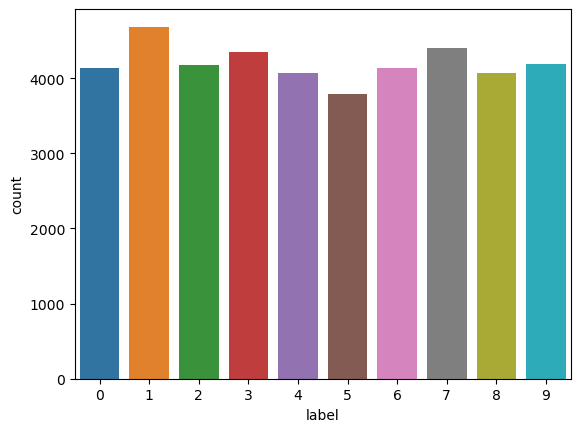

In [4]:
sns.countplot(x='label', data=train);

In [5]:
# Data normalization
X_train = X_train/255
X_test = X_test/255

In [6]:
X_train = X_train.values.reshape(-1,28,28,1)
X_test = X_test.values.reshape(-1,28,28,1)
X_train.shape, X_test.shape

((42000, 28, 28, 1), (28000, 28, 28, 1))

In [7]:
# one-hot encoding
from keras.utils.np_utils import to_categorical
y_train = to_categorical(y_train, num_classes = 10)
y_train.shape

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

(42000, 10)

In [8]:
print(train['label'].head())
y_train[0:5,:]

0    1
1    0
2    1
3    4
4    0
Name: label, dtype: int64


array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size = 0.1, random_state=42)

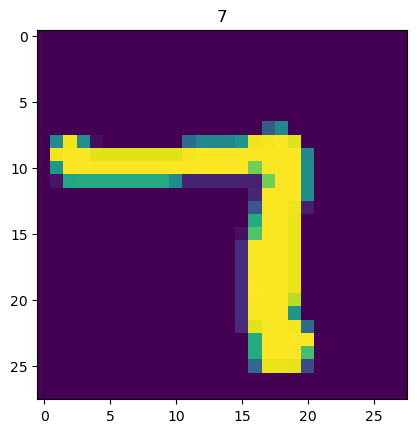

In [10]:
plt.imshow(X_train[5][:,:,0])
plt.title(y_train[5].argmax());

In [11]:
from keras.layers import Input,InputLayer, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout
from keras.models import Sequential,Model
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint,LearningRateScheduler
import keras
from keras import backend as K

In [12]:
# Building a CNN model
input_shape = (28,28,1)
X_input = Input(input_shape)

# layer 1
x = Conv2D(64,(3,3),strides=(1,1),name='layer_conv1',padding='same')(X_input)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2,2),name='maxPool1')(x)
# layer 2
x = Conv2D(32,(3,3),strides=(1,1),name='layer_conv2',padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2,2),name='maxPool2')(x)
# layer 3
x = Conv2D(32,(3,3),strides=(1,1),name='conv3',padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2,2), name='maxPool3')(x)
# fc
x = Flatten()(x)
x = Dense(64,activation ='relu',name='fc0')(x)
x = Dropout(0.25)(x)
x = Dense(32,activation ='relu',name='fc1')(x)
x = Dropout(0.25)(x)
x = Dense(10,activation ='softmax',name='fc2')(x)

conv_model = Model(inputs=X_input, outputs=x, name='Predict')
conv_model.summary()

Model: "Predict"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 layer_conv1 (Conv2D)        (None, 28, 28, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 28, 28, 64)        0         
                                                                 
 maxPool1 (MaxPooling2D)     (None, 14, 14, 64)        0         
                                                                 
 layer_conv2 (Conv2D)        (None, 14, 14, 32)        18464     
                                                           

### Note : 
In SGD 30 epochs is a reasonable choice to use although it takes a long time to compute.<br>
Adam optimizer converges quicker. Use one of the following optimizers.

In [13]:

# Adam optimizer
conv_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
conv_model.fit(X_train, y_train, epochs=5, batch_size=100, validation_data=(X_cv,y_cv))


Epoch 1/5
378/378 [==============================] - 50s 126ms/step - loss: 0.5507 - accuracy: 0.8248 - val_loss: 1.3779 - val_accuracy: 0.5062
Epoch 2/5
378/378 [==============================] - 46s 121ms/step - loss: 0.1421 - accuracy: 0.9596 - val_loss: 0.1439 - val_accuracy: 0.9569
Epoch 3/5
378/378 [==============================] - 46s 121ms/step - loss: 0.1019 - accuracy: 0.9717 - val_loss: 0.0521 - val_accuracy: 0.9840
Epoch 4/5
378/378 [==============================] - 46s 122ms/step - loss: 0.0796 - accuracy: 0.9776 - val_loss: 0.0460 - val_accuracy: 0.9840
Epoch 5/5
378/378 [==============================] - 46s 121ms/step - loss: 0.0711 - accuracy: 0.9806 - val_loss: 0.0484 - val_accuracy: 0.9852


In [14]:

# SGD optimizer
sgd = SGD(lr=0.0005, momentum=0.5, decay=0.0, nesterov=False) 
conv_model.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy'])
conv_model.fit(X_train, y_train, epochs=12, validation_data=(X_cv, y_cv))


/opt/conda/lib/python3.10/site-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/12
1182/1182 [==============================] - 53s 44ms/step - loss: 0.0484 - accuracy: 0.9868 - val_loss: 0.0349 - val_accuracy: 0.9890
Epoch 2/12
1182/1182 [==============================] - 52s 44ms/step - loss: 0.0453 - accuracy: 0.9880 - val_loss: 0.0333 - val_accuracy: 0.9900
Epoch 3/12
1182/1182 [==============================] - 52s 44ms/step - loss: 0.0408 - accuracy: 0.9889 - val_loss: 0.0320 - val_accuracy: 0.9898
Epoch 4/12
1182/1182 [==============================] - 52s 44ms/step - loss: 0.0395 - accuracy: 0.9887 - val_loss: 0.0309 - val_accuracy: 0.9907
Epoch 5/12
1182/1182 [==============================] - 52s 44ms/step - loss: 0.0369 - accuracy: 0.9898 - val_loss: 0.0309 - val_accuracy: 0.9905
Epoch 6/12
1182/1182 [==============================] - 53s 45ms/step - loss: 0.0366 - accuracy: 0.9896 - val_loss: 0.0304 - val_accuracy: 0.9917
Epoch 7/12
1182/1182 [==============================] - 52s 44ms/step - loss: 0.0364 - accuracy: 0.9899 - val_loss: 0.0303 -

In [15]:
y_pred = conv_model.predict(X_test)
y_pred = np.argmax(y_pred,axis=1)
my_submission = pd.DataFrame({'ImageId': list(range(1, len(y_pred)+1)), 'Label': y_pred})
my_submission.to_csv('submission.csv', index=False)

875/875 [==============================] - 10s 11ms/step


## Test Accuracy

Adam optimizer (10 epochs, batch size = 100) : 0.9808<br>
SGD optimizer (12 epochs) : 0.97600